In [1]:
from osgeo import gdal
from osgeo import osr

import sys; sys.path.insert(0, '..')
import os
import snappy_utils
import utils
import math

import matplotlib.pyplot as plt
import cv2
import numpy as np

### Define some settings

In [18]:
data_path = "C:\\Users\\enzot\\Documents\\Maestria\\Cianobacterias\\code\\BID\\data\\2020-03-23\\acolite_correction"
footprint = "POLYGON((-55.16629529644229 -34.7494869239046,-55.02038312603214 -34.7494869239046,-55.02038312603214 -34.868725532230165,-55.16629529644229 -34.868725532230165,-55.16629529644229 -34.7494869239046))"
S2A_wavelengths = {"B1": 443, "B2": 492, "B3": 560, "B4": 665, "B5": 704, "B6": 740, "B7": 783, "B8": 833, 
                   "B8A": 865, "B9": 945, "B11": 1373, "B12": 1614, "B13": 2202}

S2B_wavelengths = {"B1": 442, "B2": 492, "B3": 559, "B4": 665, "B5": 704, "B6": 739, "B7": 780, "B8": 833, 
                   "B8A": 864, "B9": 943, "B11": 1377, "B12": 1610, "B13": 2186}

#acolite_correction_path = os.path.join(data_path, "acolite_correction")

selected_bands = ["B2", "B3", "B4", "B5", "B6", "B7"]

### Define paths to Level-1C and Level-2A products

In [11]:
L1C_path = "data\\2020-03-23\\S2A_MSIL1C_20200323T133221_N0209_R081_T21HXB_20200323T182053.SAFE"
L2A_path = "data\\2020-03-23\\S2A_MSIL2A_20200323T133221_N0214_R081_T21HXB_20200323T185235.SAFE"

laguna_L1C_dim_path = os.path.join(data_path, "laguna-L1C.dim")
laguna_L2A_dim_path = os.path.join(data_path, "laguna-L2A.dim")

### Read Level-1C product, make subset and save as BEAM-DIMAP

In [3]:
# product = snappy_utils.read_product(L1C_path)
# subset = snappy_utils.make_subset(product, settings_BID.footprint)
# snappy_utils.write_product(subset, laguna_L1C_dim_path, "BEAM-DIMAP")
#snappy_utils.write_product(subset, os.path.join(data_path, "laguna-L1C.tif"), "GeoTiff")

### Read Level-2A product, make subset and save as BEAM-DIMAP

In [4]:
# product = snappy_utils.read_product(L2A_path)
# subset = snappy_utils.make_subset(product, settings_BID.footprint)
# snappy_utils.write_product(subset, laguna_L2A_dim_path, "BEAM-DIMAP")
#snappy_utils.write_product(subset, os.path.join(data_path, "laguna-L2A.tif"), "GeoTiff")

### Read Acolite subset, get RGB bands, get red-edge band, plot data

In [19]:
bands = {}
for file in os.listdir(data_path):
    tiff_path = ""
    for band in selected_bands:
        if file.startswith("S2A"):
            if file.endswith("rhos_" + str(S2A_wavelengths[band]) + ".tif"):
                tiff_path = os.path.join(acolite_correction_path, file)
                GPS_reference_file = tiff_path
                print(tiff_path)                
        elif file.startswith("S2B"):
            if file.endswith("rhos_" + str(S2B_wavelengths[band]) + ".tif"):
                tiff_path = os.path.join(acolite_correction_path, file)
                GPS_reference_file = tiff_path
                print(tiff_path)
        if tiff_path != "":
            ds = gdal.Open(tiff_path, gdal.GA_ReadOnly)
            rb = ds.GetRasterBand(1)
            img_array = rb.ReadAsArray()
            bands[band] = img_array
            break

C:\Users\enzot\Documents\Maestria\Cianobacterias\code\BID\data\2020-03-23\acolite_correction\S2A_MSI_2020_03_23_13_32_21_T21HXB_rhos_492.tif
C:\Users\enzot\Documents\Maestria\Cianobacterias\code\BID\data\2020-03-23\acolite_correction\S2A_MSI_2020_03_23_13_32_21_T21HXB_rhos_560.tif
C:\Users\enzot\Documents\Maestria\Cianobacterias\code\BID\data\2020-03-23\acolite_correction\S2A_MSI_2020_03_23_13_32_21_T21HXB_rhos_665.tif
C:\Users\enzot\Documents\Maestria\Cianobacterias\code\BID\data\2020-03-23\acolite_correction\S2A_MSI_2020_03_23_13_32_21_T21HXB_rhos_704.tif
C:\Users\enzot\Documents\Maestria\Cianobacterias\code\BID\data\2020-03-23\acolite_correction\S2A_MSI_2020_03_23_13_32_21_T21HXB_rhos_740.tif
C:\Users\enzot\Documents\Maestria\Cianobacterias\code\BID\data\2020-03-23\acolite_correction\S2A_MSI_2020_03_23_13_32_21_T21HXB_rhos_783.tif


### Read Level-2A subset, get RGB and red-edge bands, plot data

In [12]:
laguna_L2A = snappy_utils.read_product(laguna_L2A_dim_path)
bands = snappy_utils.get_bands(laguna_L2A, ["B2", "B3", "B4", "B5", "B6", "B7"])
GPS_reference_file = os.path.join(data_path, "laguna-L2A_RGB.tif")

### Plot data

Min: 0.005594686605036259
Max: 0.5148351788520813
Min: -0.017745353281497955
Max: 0.5418985486030579
Min: -0.00235340790823102
Max: 0.560890257358551


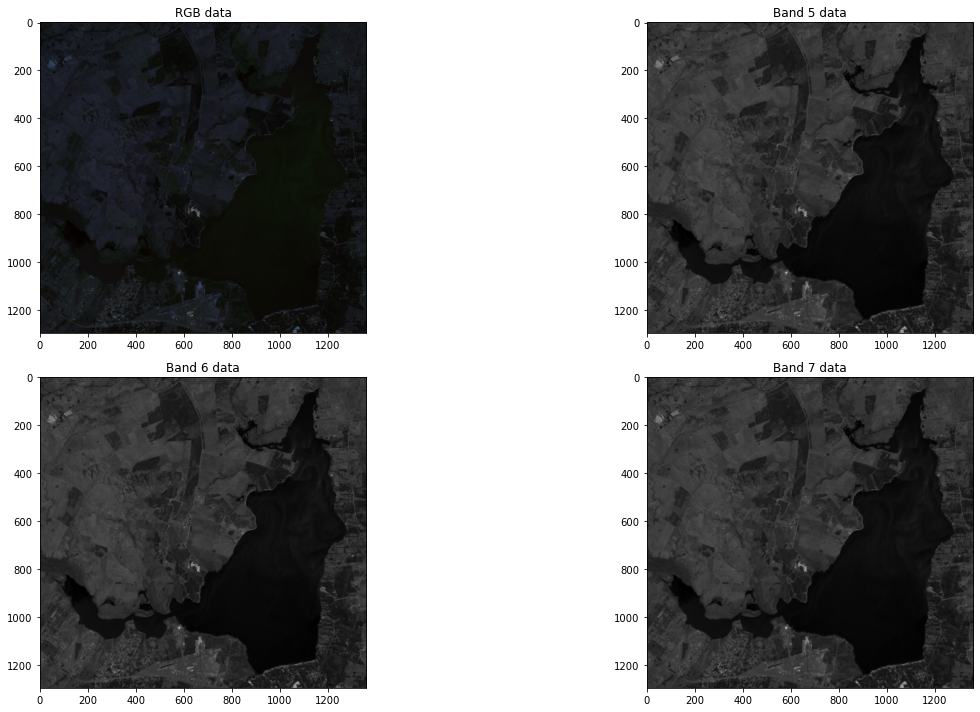

In [14]:
fig = plt.figure(figsize=(20,10))

rgb_array = np.zeros((bands["B2"].shape[0], bands["B2"].shape[1], 3), dtype=np.uint8)
rgb_array[:, :, 0] = utils.stretch_to_MinMax(bands["B2"], verbose=False)
rgb_array[:, :, 1] = utils.stretch_to_MinMax(bands["B3"], verbose=False)
rgb_array[:, :, 2] = utils.stretch_to_MinMax(bands["B4"], verbose=False)

band5_image = np.zeros((bands["B5"].shape[0], bands["B5"].shape[1], 3), dtype=np.uint8)
band5_image[:, :, 0] = utils.stretch_to_MinMax(bands["B5"], verbose=True)
band5_image[:, :, 1] = utils.stretch_to_MinMax(bands["B5"], verbose=False)
band5_image[:, :, 2] = utils.stretch_to_MinMax(bands["B5"], verbose=False)

band6_image = np.zeros((bands["B6"].shape[0], bands["B6"].shape[1], 3), dtype=np.uint8)
band6_image[:, :, 0] = utils.stretch_to_MinMax(bands["B6"], verbose=True)
band6_image[:, :, 1] = utils.stretch_to_MinMax(bands["B6"], verbose=False)
band6_image[:, :, 2] = utils.stretch_to_MinMax(bands["B6"], verbose=False)

band7_image = np.zeros((bands["B7"].shape[0], bands["B7"].shape[1], 3), dtype=np.uint8)
band7_image[:, :, 0] = utils.stretch_to_MinMax(bands["B7"], verbose=True)
band7_image[:, :, 1] = utils.stretch_to_MinMax(bands["B7"], verbose=False)
band7_image[:, :, 2] = utils.stretch_to_MinMax(bands["B7"], verbose=False)

fig.add_subplot(221).title.set_text("RGB data")
plt.imshow(rgb_array)

fig.add_subplot(222).title.set_text("Band 5 data")
plt.imshow(band5_image, cmap="gray")

fig.add_subplot(223).title.set_text("Band 6 data")
plt.imshow(band5_image, cmap="gray")

fig.add_subplot(224).title.set_text("Band 7 data")
plt.imshow(band5_image, cmap="gray")

fig.tight_layout()

### Fix resolution mismatch function

In [7]:
def match_20mto10m_resolution(array_20m):
    # create empty array to store corrected data
    fixed_array = np.zeros((array_20m.shape[0], array_20m.shape[1]), dtype=np.float32)
    # find max index for x and y with data
    max_x = -1
    max_y = -1
    for y, row in enumerate(array_20m):
        for x, val in enumerate(row):
            if y == 0 and val != 0:
                max_x += 1
            if x == 0 and val != 0:
                max_y += 1
                
    for y, row in enumerate(array_20m):
        for x, val in enumerate(row):
            if y <= max_y and x <= max_x:
                try:
                    fixed_array[2*y,2*x] = val
                    fixed_array[2*y+1,2*x] = val
                    fixed_array[2*y,2*x+1] = val
                    fixed_array[2*y+1,2*x+1] = val
                except IndexError:
                    #print("Index error at: {},{}".format(x,y))
                    pass
    return fixed_array

### Fix band 5

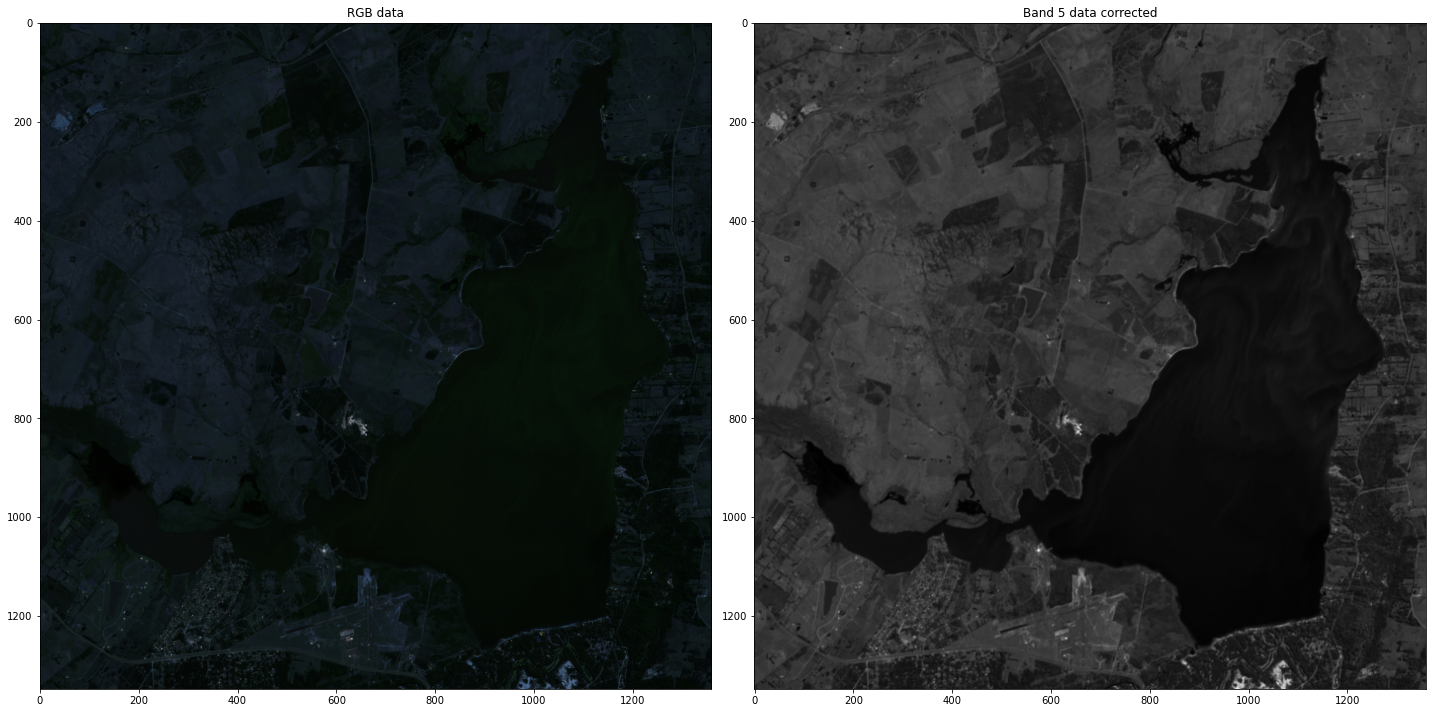

In [8]:
fig = plt.figure(figsize=(20,10))

fixed_band5 = match_20mto10m_resolution(bands["B5"])
bands["B5"] = fixed_band5

fig.add_subplot(121).title.set_text("RGB data")
plt.imshow(rgb_array)

fig.add_subplot(122).title.set_text("Band 5 data corrected")
#plt.imshow(fixed_band5, cmap="gray", interpolation=None, vmin=np.amin(fixed_band5), vmax=np.amax(fixed_band5))
#plt.colorbar()
plt.imshow(fixed_band5, cmap="gray")


fig.tight_layout()

### Fix band 6

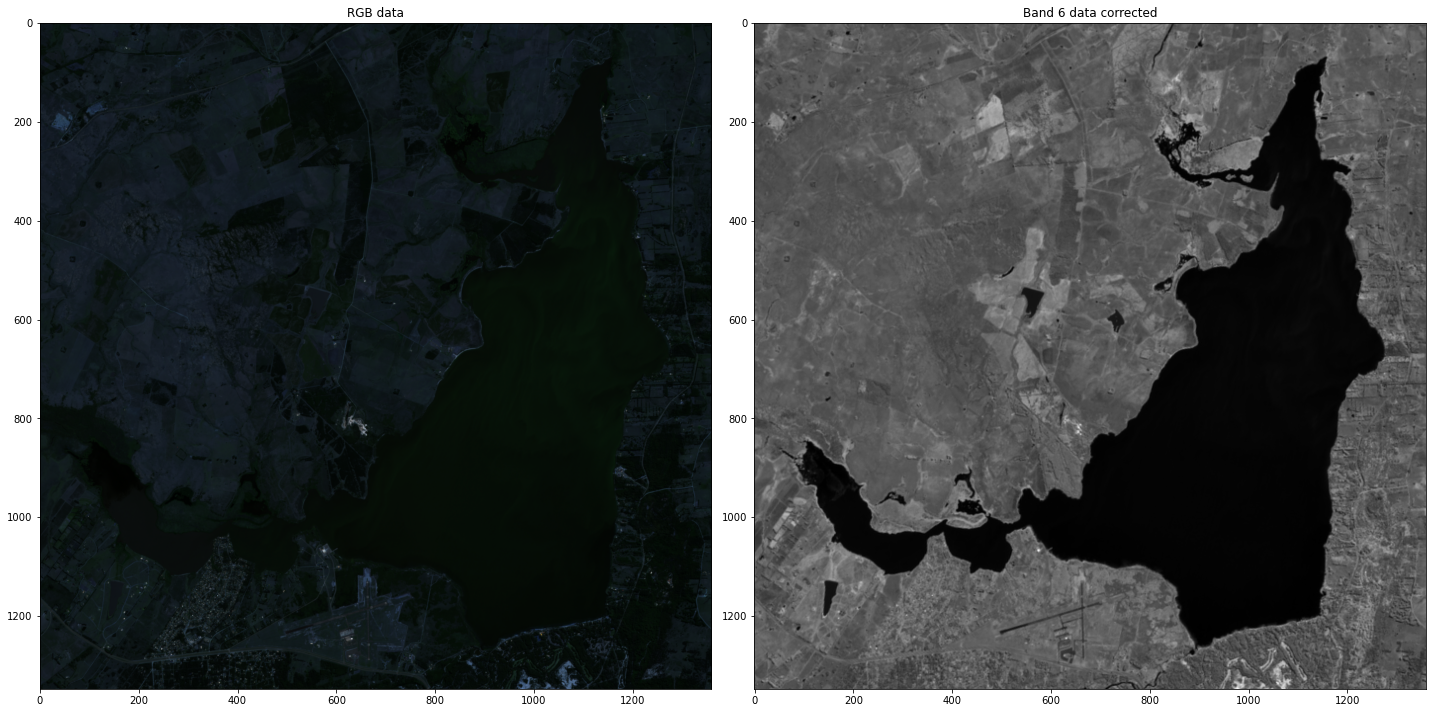

In [9]:
fig = plt.figure(figsize=(20,10))

fixed_band6 = match_20mto10m_resolution(bands["B6"])
bands["B6"] = fixed_band6

fig.add_subplot(121).title.set_text("RGB data")
plt.imshow(rgb_array)

fig.add_subplot(122).title.set_text("Band 6 data corrected")
plt.imshow(fixed_band6, cmap="gray")

fig.tight_layout()

### Fix band 7

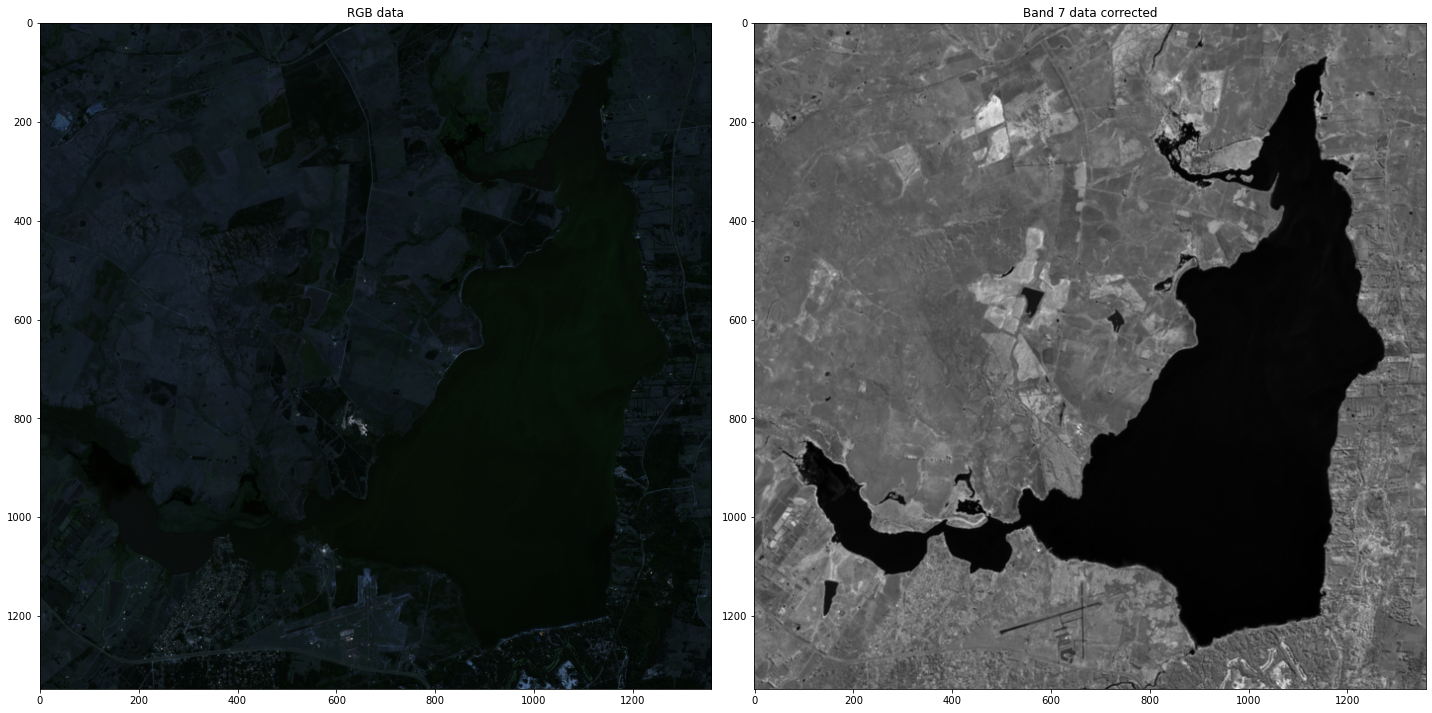

In [10]:
fig = plt.figure(figsize=(20,10))

fixed_band7 = match_20mto10m_resolution(bands["B7"])
bands["B7"] = fixed_band7

fig.add_subplot(121).title.set_text("RGB data")
plt.imshow(rgb_array)

fig.add_subplot(122).title.set_text("Band 7 data corrected")
plt.imshow(fixed_band7, cmap="gray")

fig.tight_layout()

### Make NDCI array and plot it

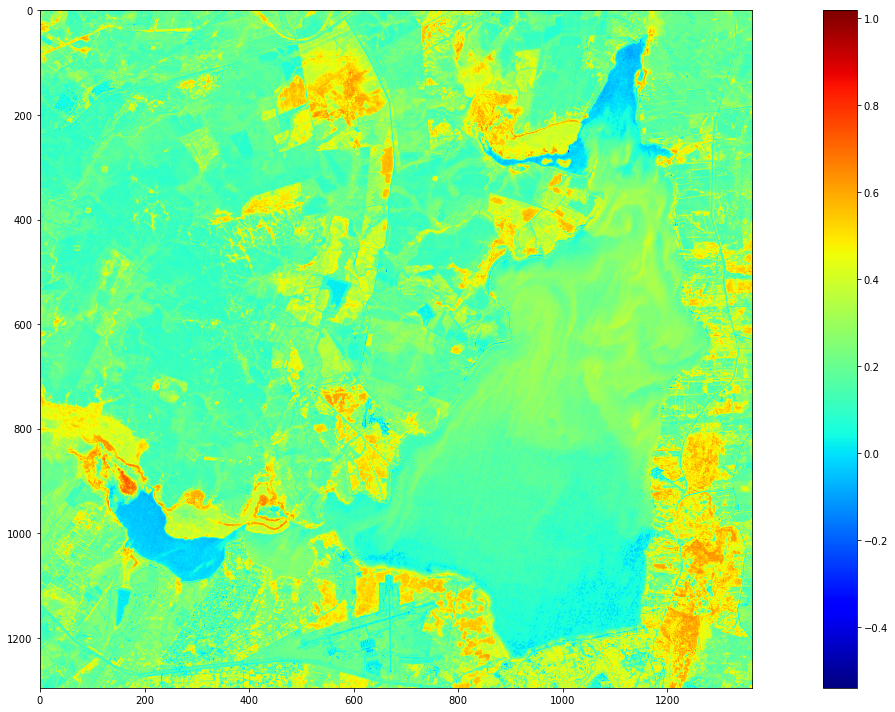

In [15]:
NDCI = (bands["B5"] - bands["B4"])/(bands["B5"] + bands["B4"])
fig = plt.figure(figsize=(20,10))
plt.imshow(NDCI, cmap="jet", interpolation=None, vmin=np.amin(NDCI), vmax=np.amax(NDCI))
plt.colorbar()
fig.tight_layout()

### Calculate Chl with Moses formula

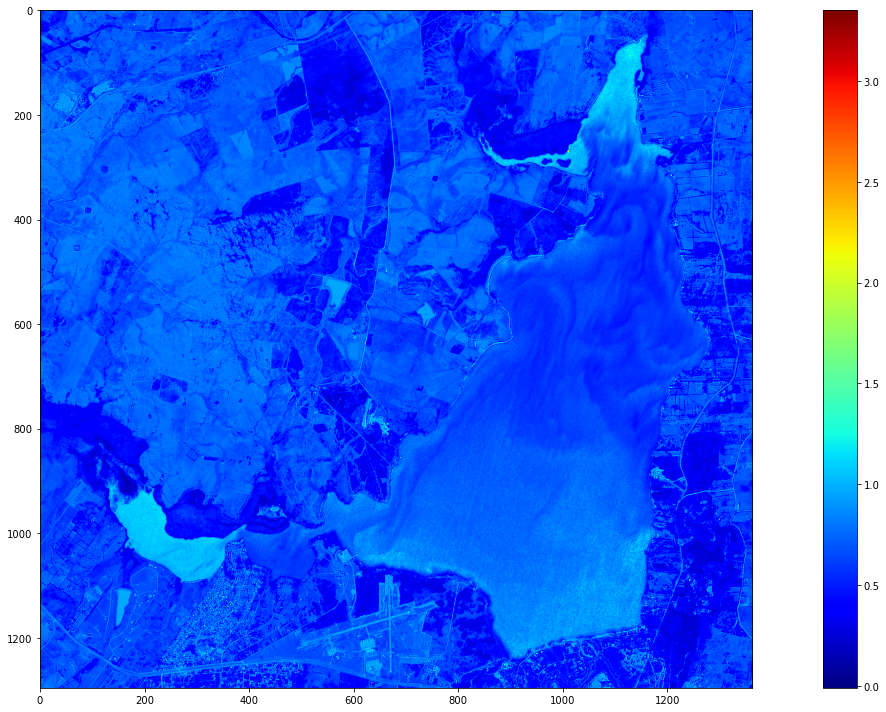

In [16]:
CHL = bands["B4"]/bands["B5"]
fig = plt.figure(figsize=(20,10))
plt.imshow(CHL, cmap="jet", interpolation=None, vmin=np.amin(CHL), vmax=np.amax(CHL))
plt.colorbar()
fig.tight_layout()

### Make index with bands 4,5,6,7

B4 min, max:  -0.0014884688 0.6612743
B5 min, max:  0.0055946866 0.5148352
B6 min, max:  -0.017745353 0.54189855
B7 min, max:  -0.002353408 0.56089026
--------
index1 min, max:  -363.64297 110.7887
index1 mean:  1.8032646494021567
index1 std:  2.7171765126855485
--------
index2 min, max:  -1.0184629 0.54034233
index2 mean:  -0.23110314285047157
index2 std:  0.13350859811495358
--------
index3 min, max:  -297.701 112.82247
index3 mean:  1.5035549755935234
index3 std:  2.1796156350290876


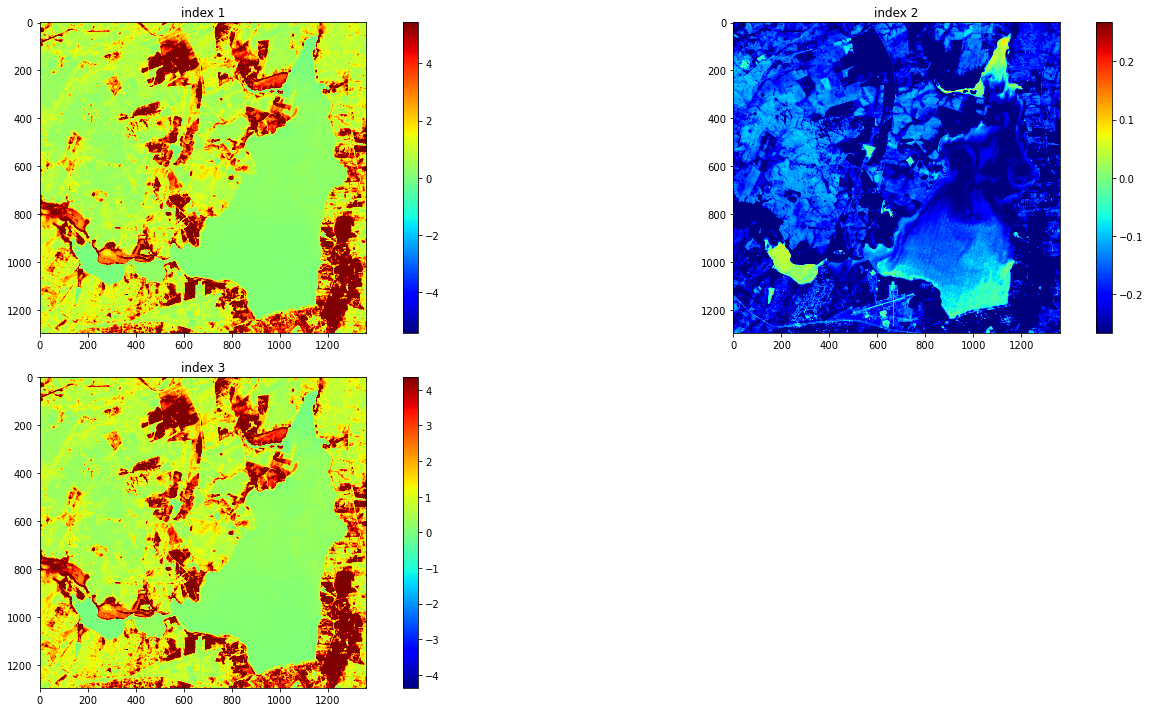

In [17]:
print("B4 min, max: ", np.amin(bands["B4"]), np.amax(bands["B4"]))
print("B5 min, max: ", np.amin(bands["B5"]), np.amax(bands["B5"]))
print("B6 min, max: ", np.amin(bands["B6"]), np.amax(bands["B6"]))
print("B7 min, max: ", np.amin(bands["B7"]), np.amax(bands["B7"]))
print("--------")

index1 = ((1/bands["B4"]) - (1/bands["B5"]))*bands["B7"]
print("index1 min, max: ", np.amin(index1), np.amax(index1))
print("index1 mean: ", np.mean(index1, dtype=np.float64))
print("index1 std: ", np.std(index1, dtype=np.float64))
print("--------")
index2 = ((1/bands["B5"]) - (1/bands["B4"]))/((1/bands["B5"]) + (1/bands["B4"]))
print("index2 min, max: ", np.amin(index2), np.amax(index2))
print("index2 mean: ", np.mean(index2, dtype=np.float64))
print("index2 std: ", np.std(index2, dtype=np.float64))
print("--------")
index3 = (1/bands["B4"] - 1/bands["B5"])*bands["B6"]
print("index3 min, max: ", np.amin(index3), np.amax(index3))
print("index3 mean: ", np.mean(index3, dtype=np.float64))
print("index3 std: ", np.std(index3, dtype=np.float64))

fig = plt.figure(figsize=(20,10))

fig.add_subplot(221).title.set_text("index 1")
plt.imshow(index1, cmap="jet", interpolation=None, vmin=np.std(index1, dtype=np.float64)*-2, vmax=np.std(index1, dtype=np.float64)*2)
plt.colorbar()

fig.add_subplot(222).title.set_text("index 2")
plt.imshow(index2, cmap="jet", interpolation=None, vmin=np.std(index2, dtype=np.float64)*-2, vmax=np.std(index2, dtype=np.float64)*2)
plt.colorbar()

fig.add_subplot(223).title.set_text("index 3")
plt.imshow(index3, cmap="jet", interpolation=None, vmin=np.std(index3, dtype=np.float64)*-2, vmax=np.std(index3, dtype=np.float64)*2)
plt.colorbar()

fig.tight_layout()

### Create GeoTiff for band 7

In [28]:
# band 7 geotiff path
laguna_band7_geotiff_path = os.path.join(data_path, "laguna-band7.tif")

ds = gdal.Open(GPS_reference_file)

# set geotransform
nx = bands["B7"].shape[1]
ny = bands["B7"].shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_band7_geotiff_path, nx, ny, 1, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(bands["B7"])   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### Create GeoTiff for band 6

In [29]:
# band 6 geotiff path
laguna_band6_geotiff_path = os.path.join(data_path, "laguna-band6.tif")

ds = gdal.Open(GPS_reference_file)

# set geotransform
nx = bands["B6"].shape[1]
ny = bands["B6"].shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_band6_geotiff_path, nx, ny, 1, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(bands["B6"])   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### Create GeoTiff for band 5

In [8]:
# band 5 geotiff path
laguna_band5_geotiff_path = os.path.join(data_path, "laguna-band5.tif")

ds = gdal.Open(GPS_reference_file)

# set geotransform
nx = bands["B5"].shape[1]
ny = bands["B5"].shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_band5_geotiff_path, nx, ny, 1, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(bands["B5"])   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### Create GeoTiff for band 4

In [9]:
# band 4 geotiff path
laguna_band4_geotiff_path = os.path.join(data_path, "laguna-band4.tif")

ds = gdal.Open(GPS_reference_file)

# set geotransform
nx = bands["B4"].shape[1]
ny = bands["B4"].shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_band4_geotiff_path, nx, ny, 1, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(bands["B4"])   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### Create GeoTiff for NDCI

In [20]:
# NDCI geotiff path
laguna_NDCI_geotiff_path = os.path.join(data_path, "NDCI.tif")

ds = gdal.Open(GPS_reference_file)

# set geotransform
nx = NDCI.shape[1]
ny = NDCI.shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_NDCI_geotiff_path, nx, ny, 1, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(NDCI)   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### Create GeoTiff for Moses' Chl

In [21]:
# Moses CHL geotiff path
laguna_CHL_geotiff_path = os.path.join(data_path, "laguna-CHL.tif")

ds = gdal.Open(GPS_reference_file)

# set geotransform
nx = CHL.shape[1]
ny = CHL.shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_CHL_geotiff_path, nx, ny, 1, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(CHL)   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### Create GeoTiff for index 1

In [22]:
# index1 geotiff path
laguna_index1_geotiff_path = os.path.join(data_path, "laguna-index1.tif")

ds = gdal.Open(GPS_reference_file)

# set geotransform
nx = index1.shape[1]
ny = index1.shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_index1_geotiff_path, nx, ny, 1, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(index1)   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### Create GeoTiff for index 2

In [23]:
# index2 geotiff path
laguna_index2_geotiff_path = os.path.join(data_path, "laguna-index2.tif")

ds = gdal.Open(GPS_reference_file)

# set geotransform
nx = index2.shape[1]
ny = index2.shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_index2_geotiff_path, nx, ny, 1, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(index2)   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### Create GeoTiff for index3

In [24]:
# index3 geotiff path
laguna_index3_geotiff_path = os.path.join(data_path, "laguna-index3.tif")

ds = gdal.Open(GPS_reference_file)

# set geotransform
nx = index3.shape[1]
ny = index3.shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_index3_geotiff_path, nx, ny, 1, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(index3)   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None

### Create GeoTiff for RGB

In [25]:
# index3 geotiff path
laguna_RGB_geotiff_path = os.path.join(data_path, "laguna-RGB.tif")

ds = gdal.Open(GPS_reference_file)

# set geotransform
nx = bands["B2"].shape[1]
ny = bands["B2"].shape[0]

# create the 3-band raster file
dst_ds = gdal.GetDriverByName('GTiff').Create(laguna_RGB_geotiff_path, nx, ny, 3, gdal.GDT_Float32)

dst_ds.SetGeoTransform(ds.GetGeoTransform())    # specify coords
dst_ds.SetProjection(ds.GetProjection()) # export coords to file
dst_ds.GetRasterBand(1).WriteArray(bands["B2"])   # write band to the raster
dst_ds.GetRasterBand(2).WriteArray(bands["B3"])   # write band to the raster
dst_ds.GetRasterBand(3).WriteArray(bands["B4"])   # write band to the raster
dst_ds.FlushCache()                     # write to disk
dst_ds = None